In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from scipy.optimize import curve_fit
from scipy.signal import spectrogram, periodogram, butter, filtfilt
import matplotlib.dates as mdates
from scipy.fft import fftshift
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL

### Time Series Descomposition

Para este análisis se utiliza el campo GROCERIES I de la tabla de train con el objetivo de simplificar el análisis. 

In [5]:
# Upload datasets
datasets = {}
datasets["oil"] = pd.read_csv("data/oil.csv")
datasets["stores"] = pd.read_csv("data/stores.csv")
datasets["train"] = pd.read_csv("data/train.csv")
datasets["test"] = pd.read_csv("data/test.csv")
datasets["transactions"] = pd.read_csv("data/transactions.csv")
datasets["holidays"] = pd.read_csv("data/holidays_events.csv")

In [6]:
# Transform rows to datetime
for _, dataset in datasets.items():
    if "date" in dataset.columns:
        dataset["date"] = pd.to_datetime(dataset["date"])

In [7]:
family = "GROCERY I"
sales_per_day = datasets["train"][datasets["train"]["family"] == family].groupby(datasets["train"]['date'].dt.date).sum()["sales"]



### Autocorrelation

In [8]:
#x = pd.plotting.autocorrelation_plot(sales_per_day.values)
#x.plot()

Primero se hace un análisis de la serie de tiempo para determinar si la serie es estacionario. Se hace utiliza el test de Dickey-Fuller.

In [9]:
adfuller(sales_per_day.values)

(-3.448762638791253,
 0.00940471087835237,
 25,
 1658,
 {'1%': -3.434300212992577,
  '5%': -2.863284793874921,
  '10%': -2.567698886736967},
 39138.360502681644)

Dado que de obtiene un p-valor de 0.009 podemos decir que la serie es estacionaria. Por lo que la serie es invariante a lo largo del tiempo

Se grafica la función de autocorrelación muestreal

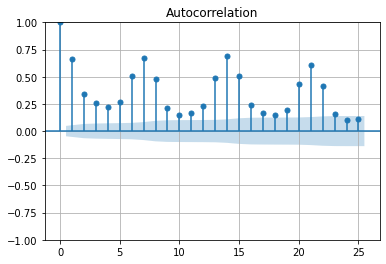

In [10]:
plot_acf(sales_per_day.values, lags=25)
plt.grid()
plt.show()

Se grafica la función de autocorrelación parcial

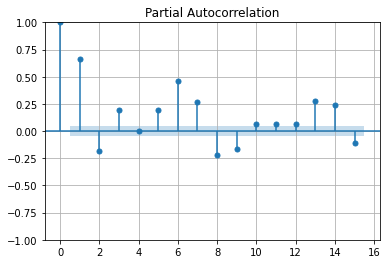

In [11]:
plot_pacf(sales_per_day.values, lags=15, method="ywm")
plt.grid()
plt.show()

### Additive descomposition

Posteriormente se realiza la descomposición de la serie de tiempo usando seasonal_decompose de forma aditiva

<Figure size 1440x4320 with 0 Axes>

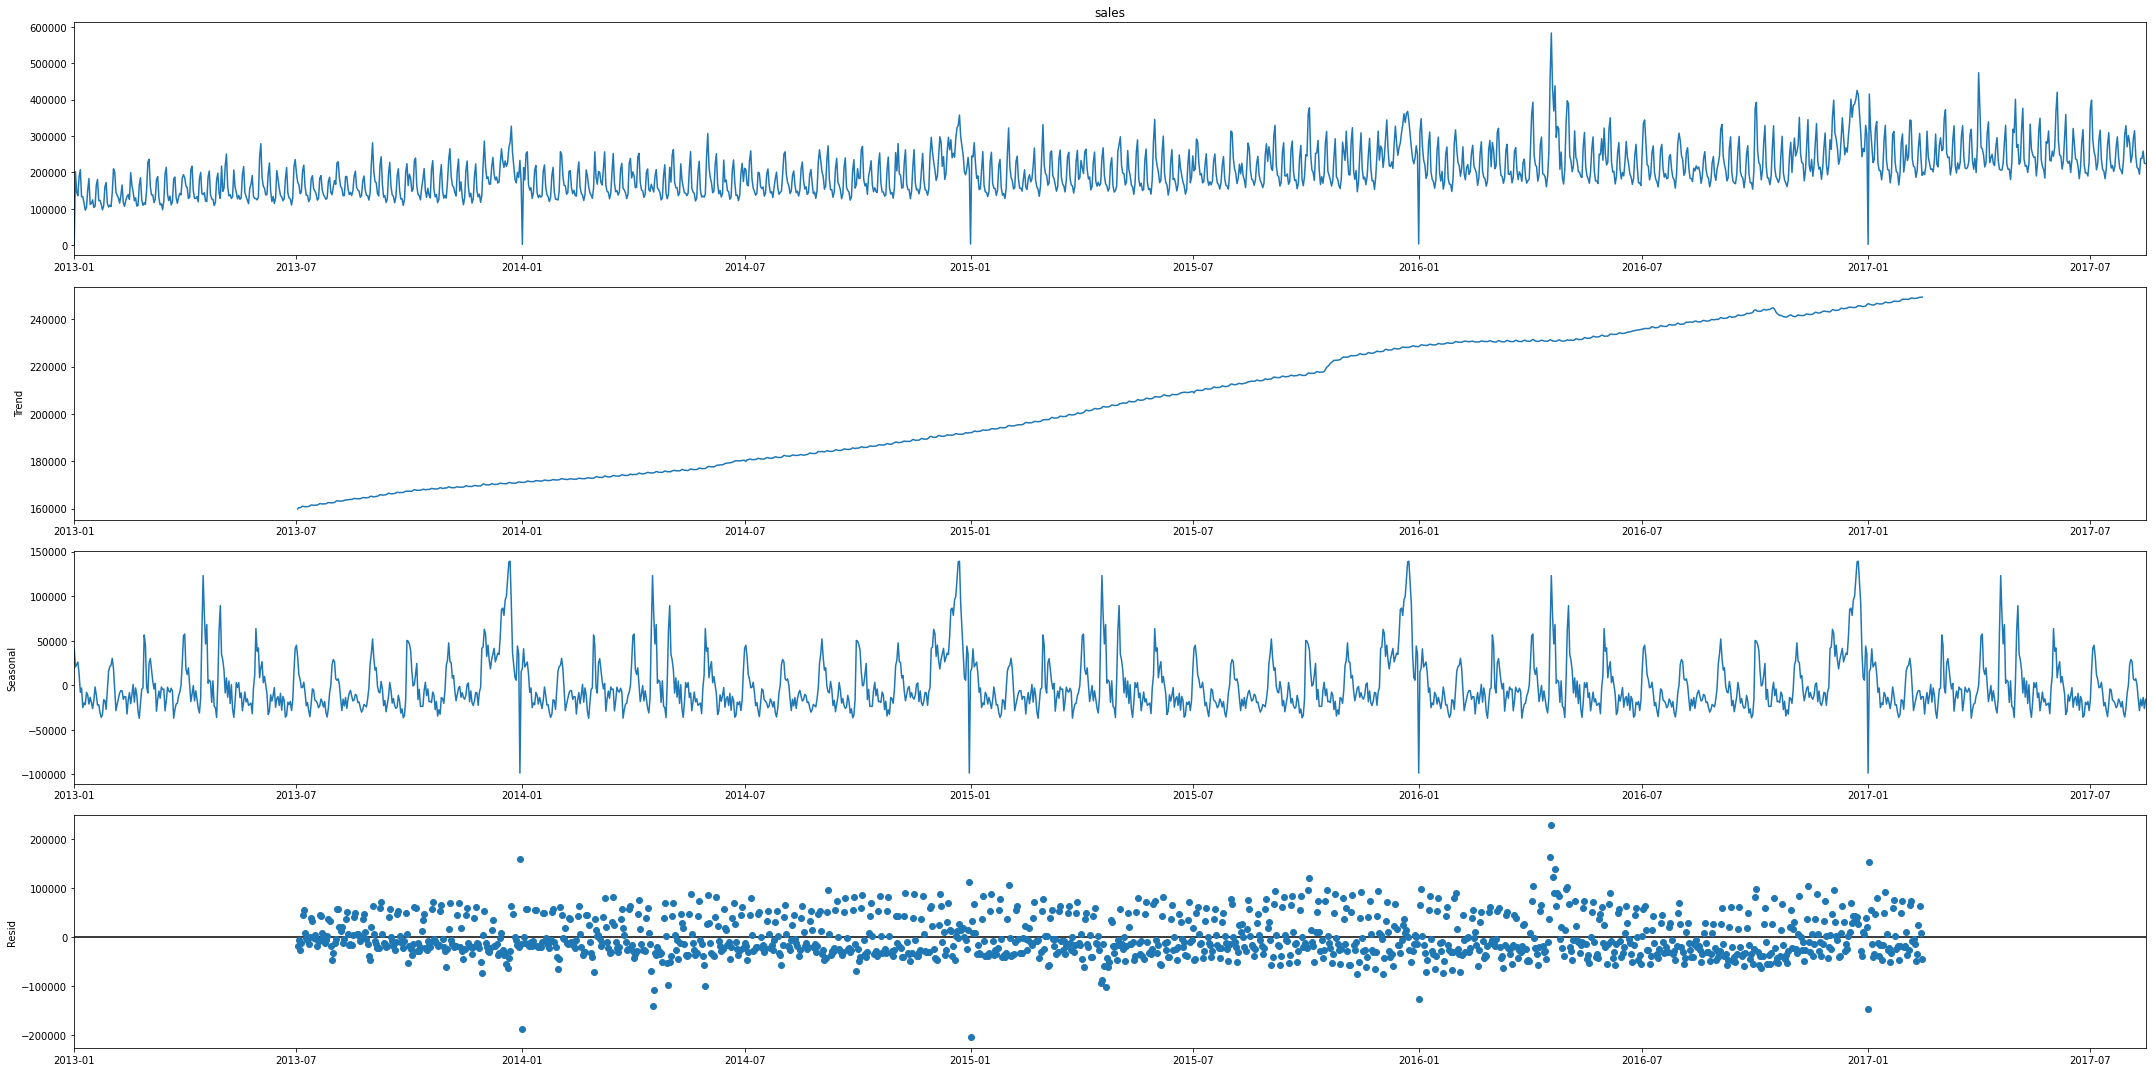

<Figure size 1440x4320 with 0 Axes>

In [12]:
result = seasonal_decompose(sales_per_day, model='additive', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Multiplicative descomposition

Luego se hace la descomposición de forma multiplicativa

<Figure size 1440x4320 with 0 Axes>

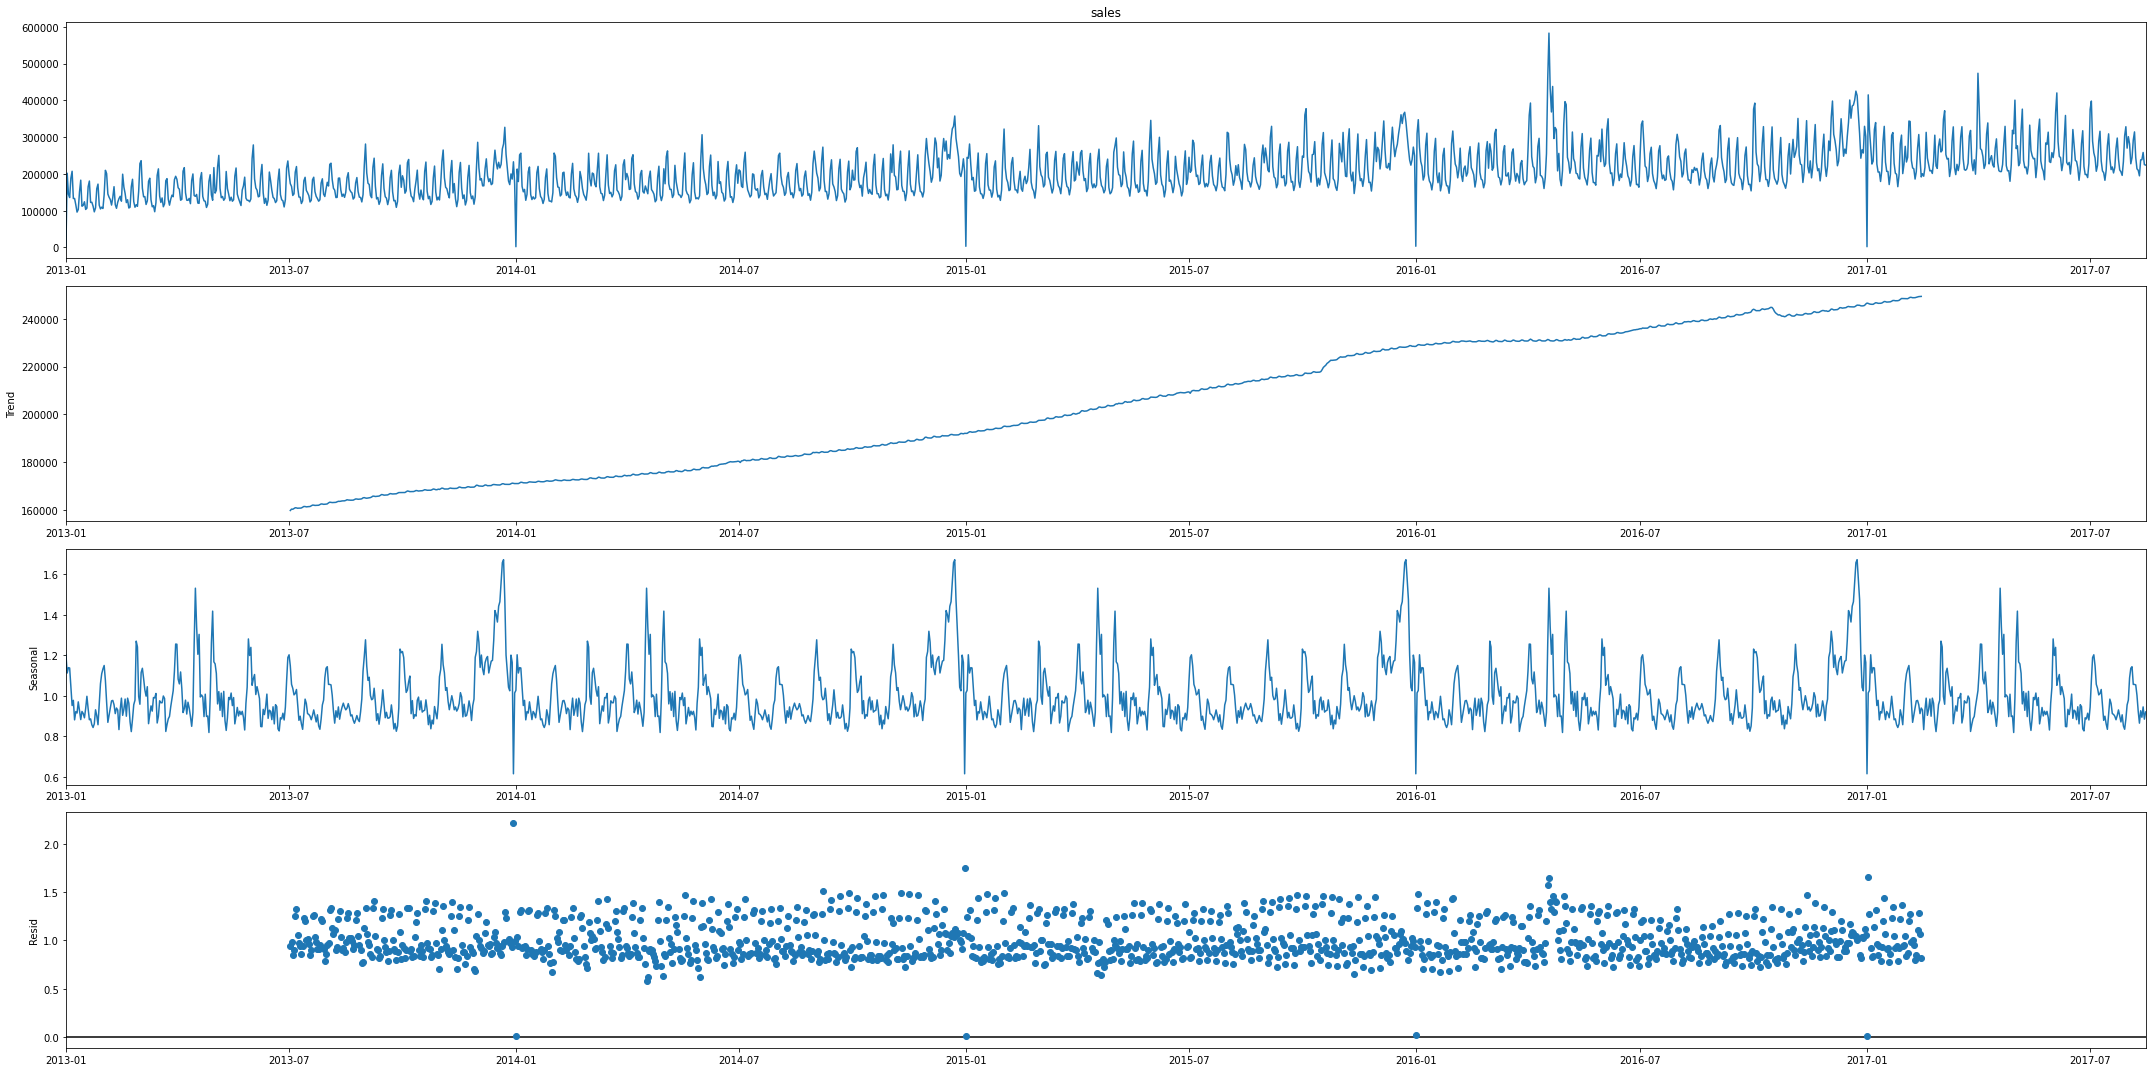

<Figure size 1440x4320 with 0 Axes>

In [13]:
result = seasonal_decompose(sales_per_day, model='multiplicative', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Descomposition using LOESS

<Figure size 1440x4320 with 0 Axes>

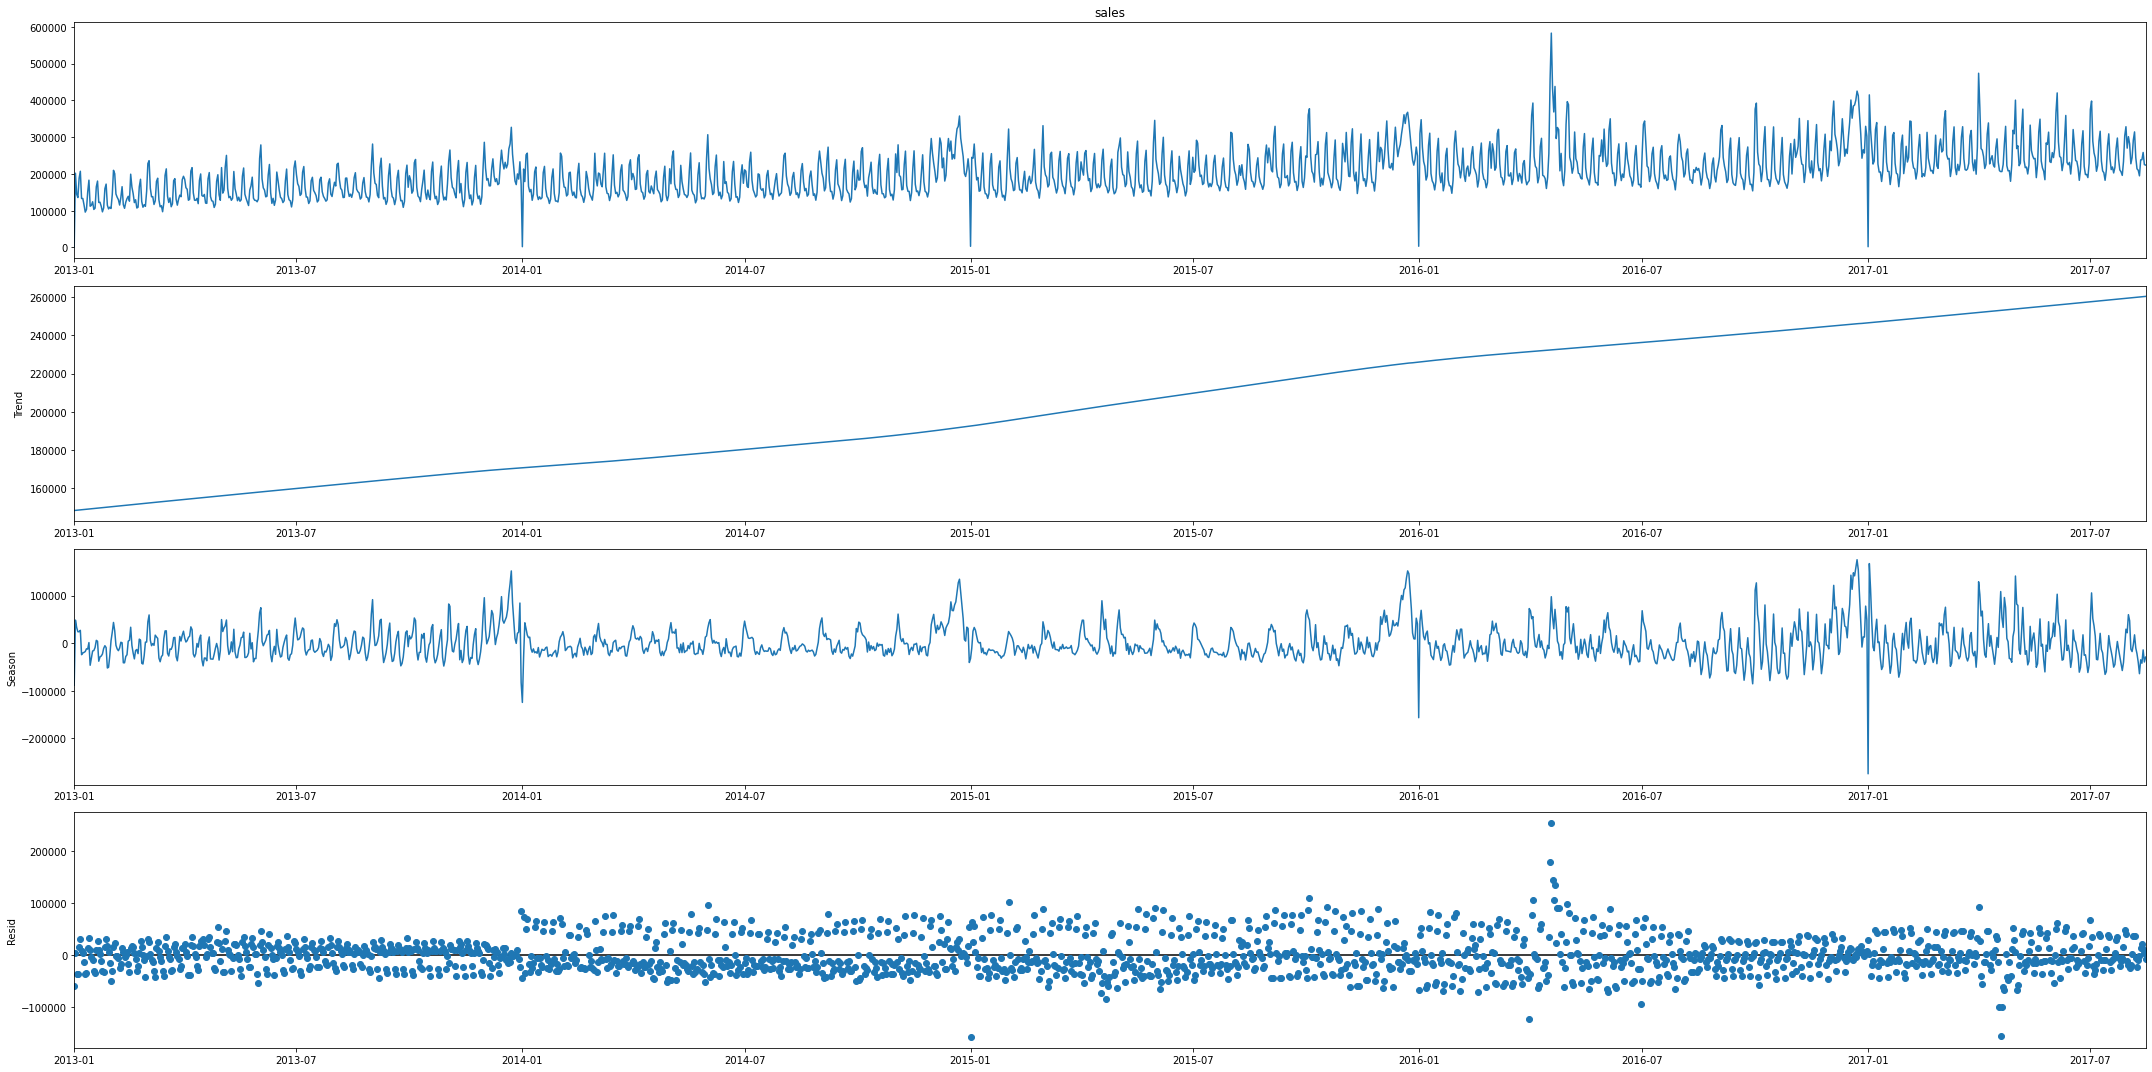

<Figure size 1440x4320 with 0 Axes>

In [14]:
res = STL(sales_per_day, period=365).fit()
res.plot()
plt.figure(figsize=(20, 60))

### Trend

Se obtiene la tendencia a través de mínimos cuadrados

In [15]:

def plot_trend(series, model="linear"):

    if model == "cuadratic":
        def objective(x, a, b, c):
            return a * x + b * x ** 2 + c
    else:
        def objective(x, a, b):
            return a * x + b

    x = mdates.date2num(series.index)
    y = series.values

    popt, _ = curve_fit(objective, x, y)
    print(f"Model coefficients {popt}")

    x_line = np.arange(min(x), max(x), 1)
    y_line = objective(x_line, *popt)

    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.plot(x_line, y_line)
    plt.plot(x, y)


    

Model coefficients [ 7.13101681e+01 -9.76180589e+05]


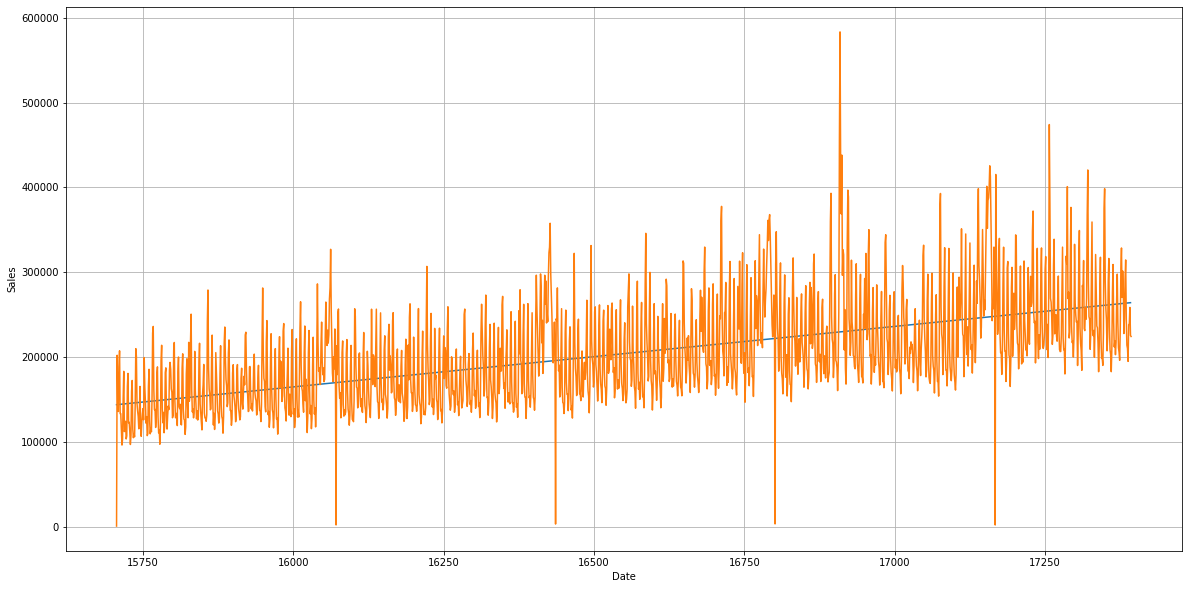

In [16]:
plot_trend(sales_per_day)

Model coefficients [ 1.93882411e+02 -3.70321948e-03 -1.98955025e+06]


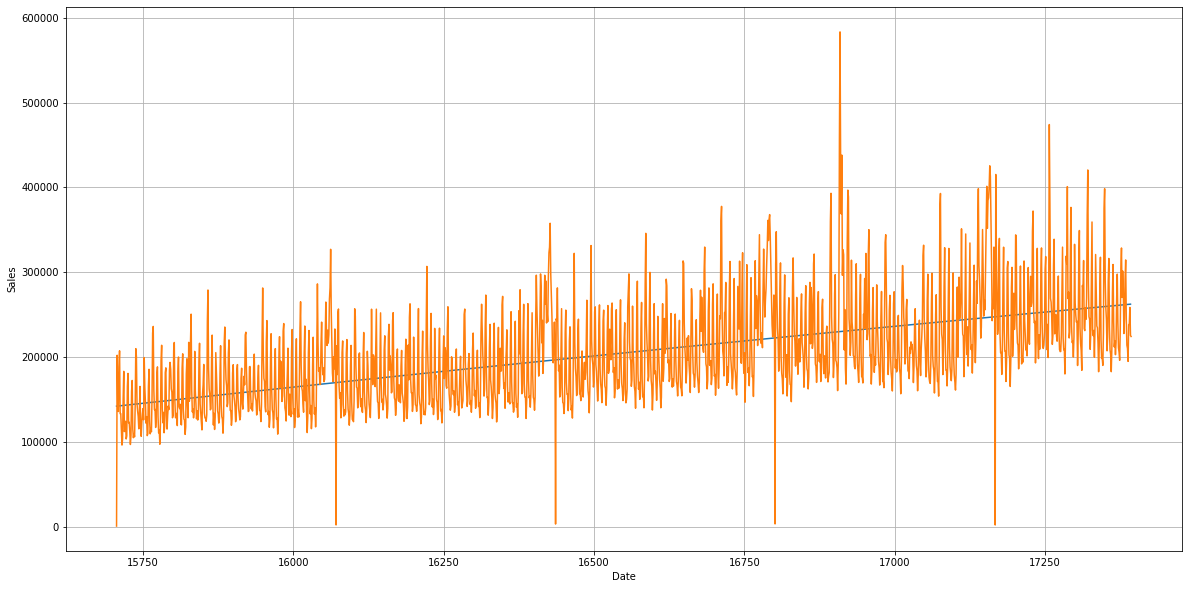

In [17]:
plot_trend(sales_per_day, model="cuadratic")

### Cycle

Se grafica el periodograma de la serie

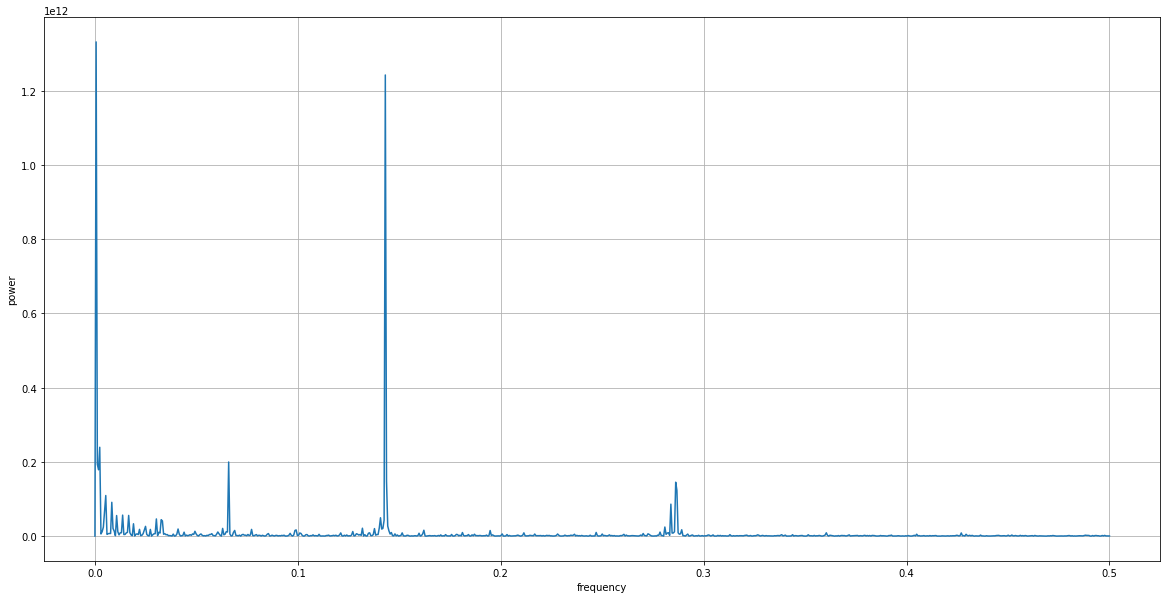

In [44]:
freq, power  = periodogram(sales_per_day.values)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)


Puede observarse una componenente semanal bastante marcada. Se observan picos a periodos de 3,5 días y dos semanas.

Se obtiene el espectrograma

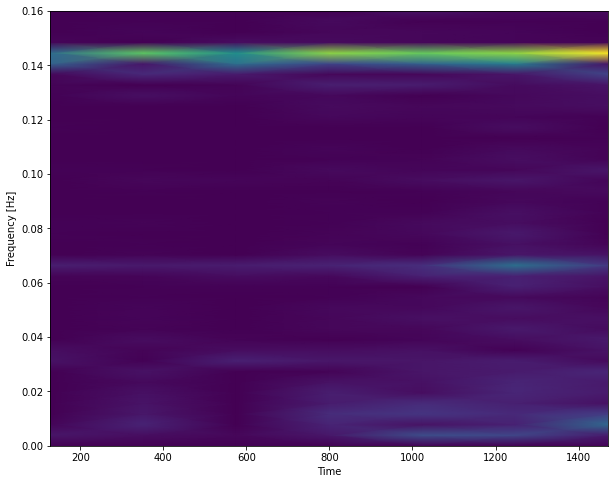

In [18]:
#<plt.plot(spectrogram(sales_per_day.values))
f, t, Sxx = spectrogram(sales_per_day.values)

plt.figure(figsize=(10, 8))
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.ylim([0, 0.16])
plt.show()

Se puede observar en el espectrograma que se produce ciclos a una frecuencia de aproximadamente 0.14 Hz, esto corresponde a un ciclo semanal.

In [15]:
#plt.figure(figsize=(10, 8))
#powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sales_per_day.values, Fs=1, cmap="rainbow")

Se utiliza un filtro pasa banda para determinar la componente cicloidal

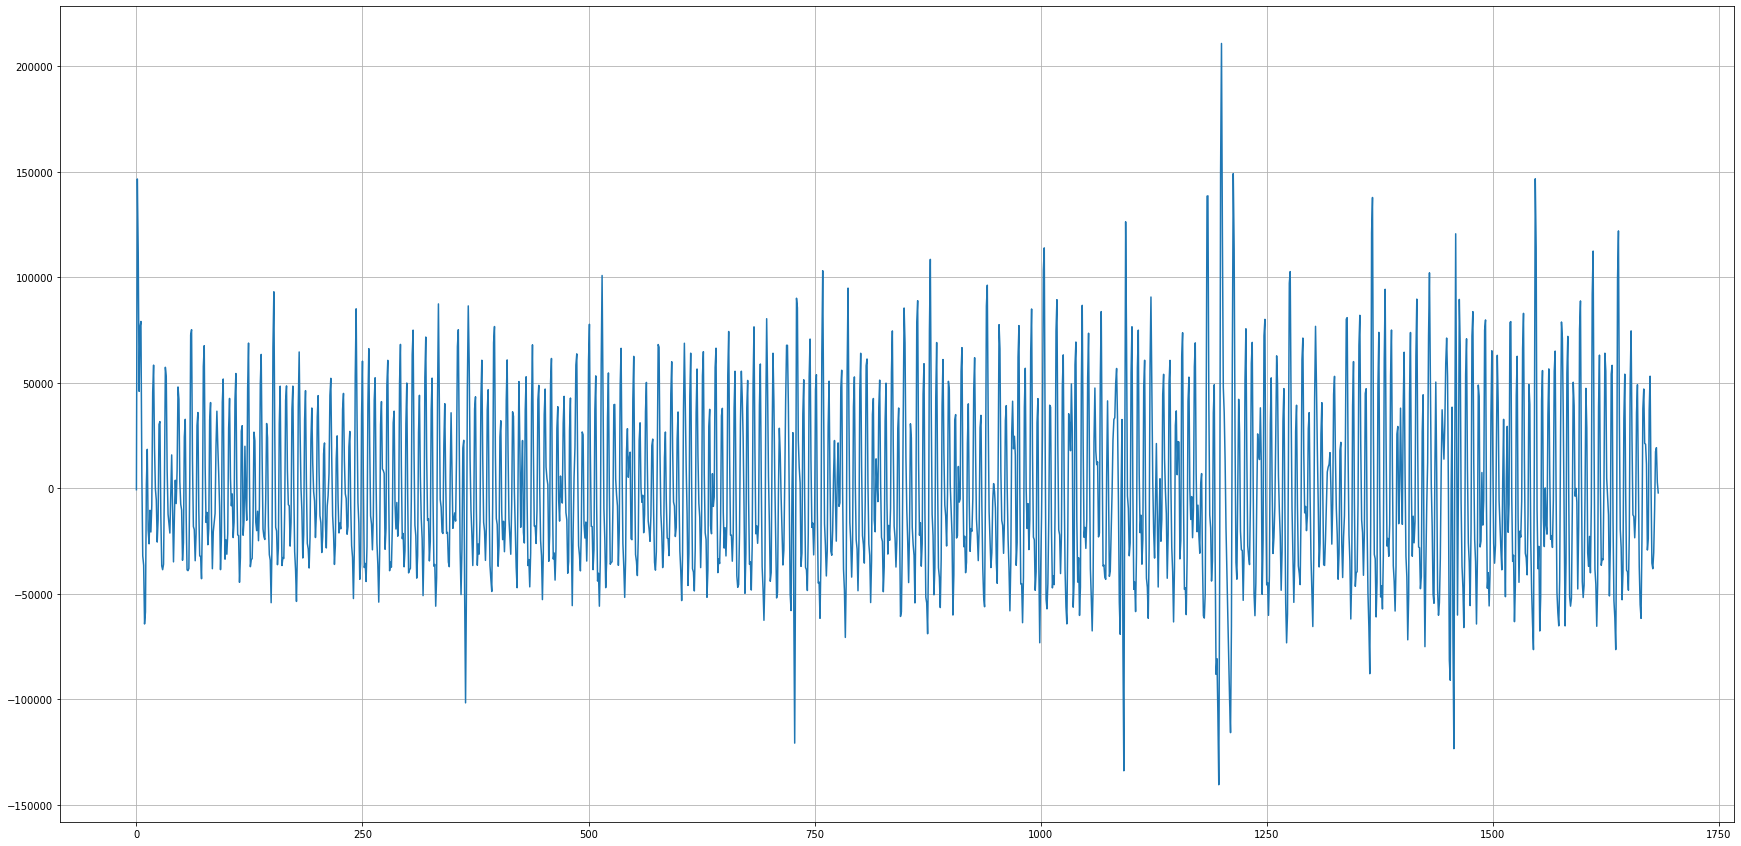

In [55]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cut / nyq for cut in cutoff]
    b, a = butter(order, normal_cutoff, btype="bandpass", analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


#filtered_data = butter_highpass_filter(sales_per_day.values, 100, 1000)
#plt.grid()
#plt.plot(filtered_data)

filtered_data = butter_bandpass_filter(sales_per_day.values, [50, 300], 1000)
plt.grid()
plt.plot(filtered_data)


Se observa

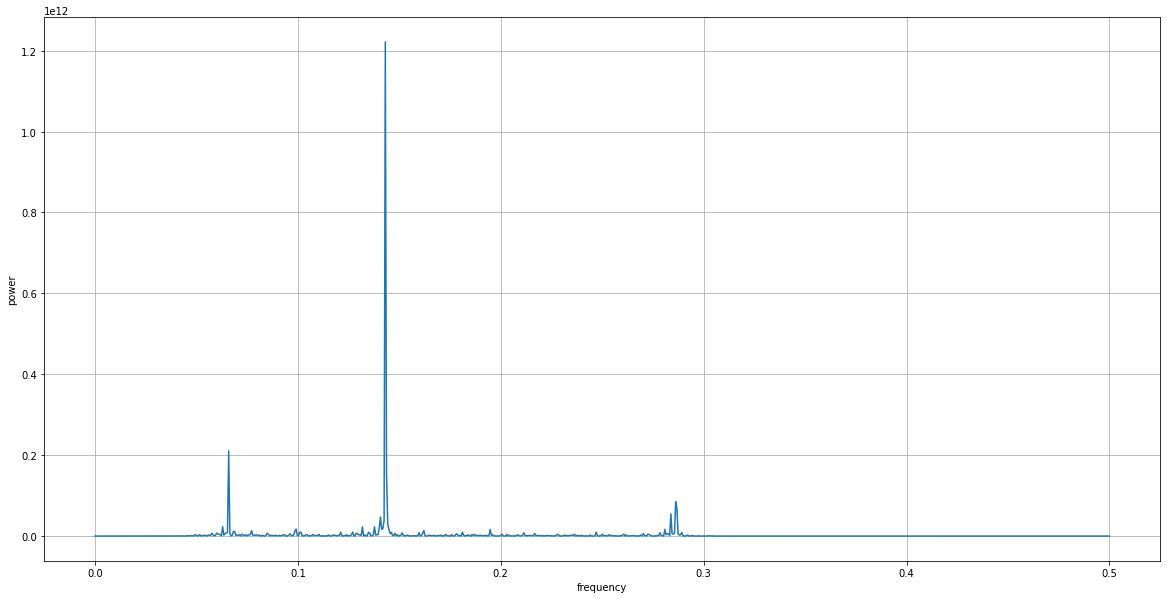

In [56]:
freq, power  = periodogram(filtered_data)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)

### ARIMA

Se modela la serie usando ARIMA, se obtienen los parámetros a partir de las gráficas de autocorrelación

In [16]:
d = 0 # No differenciation needed since time series is already stationary
q = 23
p = 3
arima = ARIMA(sales_per_day.values, order=(p, d, q))
arima_res = arima.fit()
print(arima_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1684
Model:                ARIMA(3, 0, 23)   Log Likelihood              -19993.539
Date:                Fri, 27 May 2022   AIC                          40043.077
Time:                        21:41:33   BIC                          40195.087
Sample:                             0   HQIC                         40099.379
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.04e+05   6699.987     30.441      0.000    1.91e+05    2.17e+05
ar.L1          0.4402      0.908      0.485      0.628      -1.339       2.219
ar.L2          0.0002      1.127      0.000      1.0

Se grafican los residuos

<AxesSubplot:>

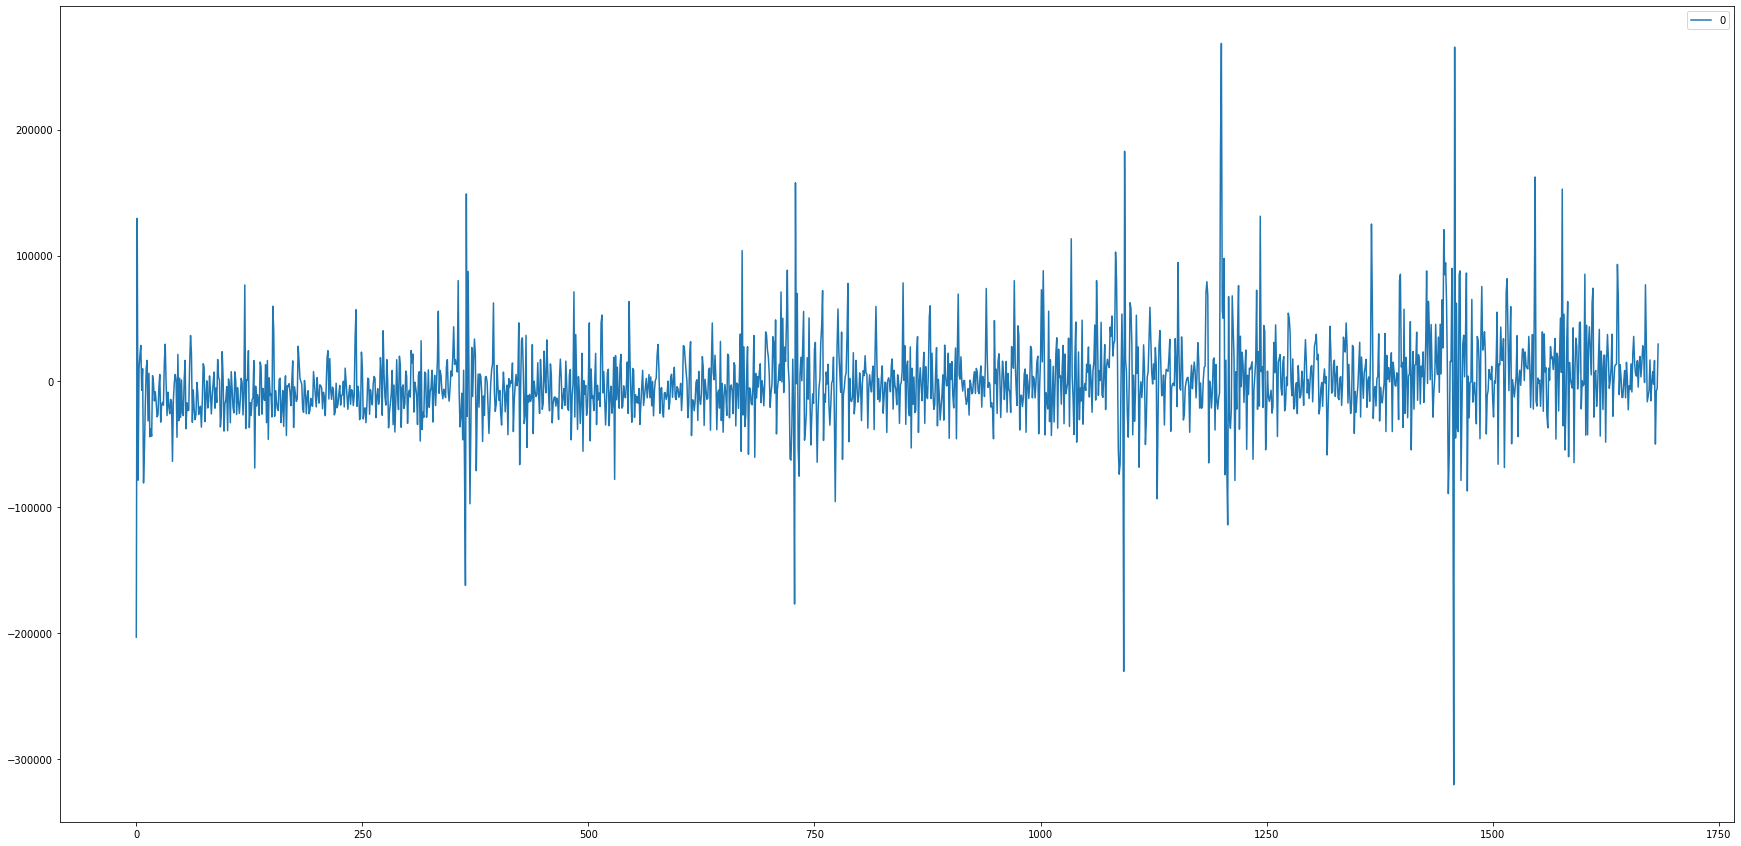

In [17]:
residuals = pd.DataFrame(arima_res.resid)
residuals.plot()


In [18]:
residuals.describe()

,0
count,1684.000000
mean,7.686707
std,33946.458686
min,-320530.328132
25%,-17387.827029
50%,-1726.503716
75%,14057.454652
max,268524.872896


Se hace la predicción y se grafica el intervalo de confianza

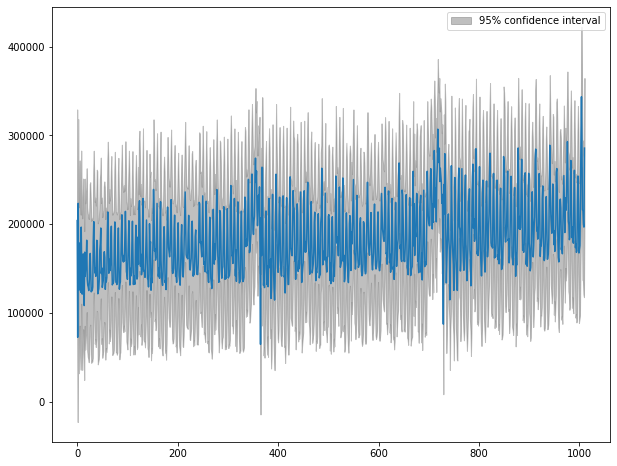

In [19]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plot_predict(arima_res, start=0, end=N + l, ax=ax)
plt.show()

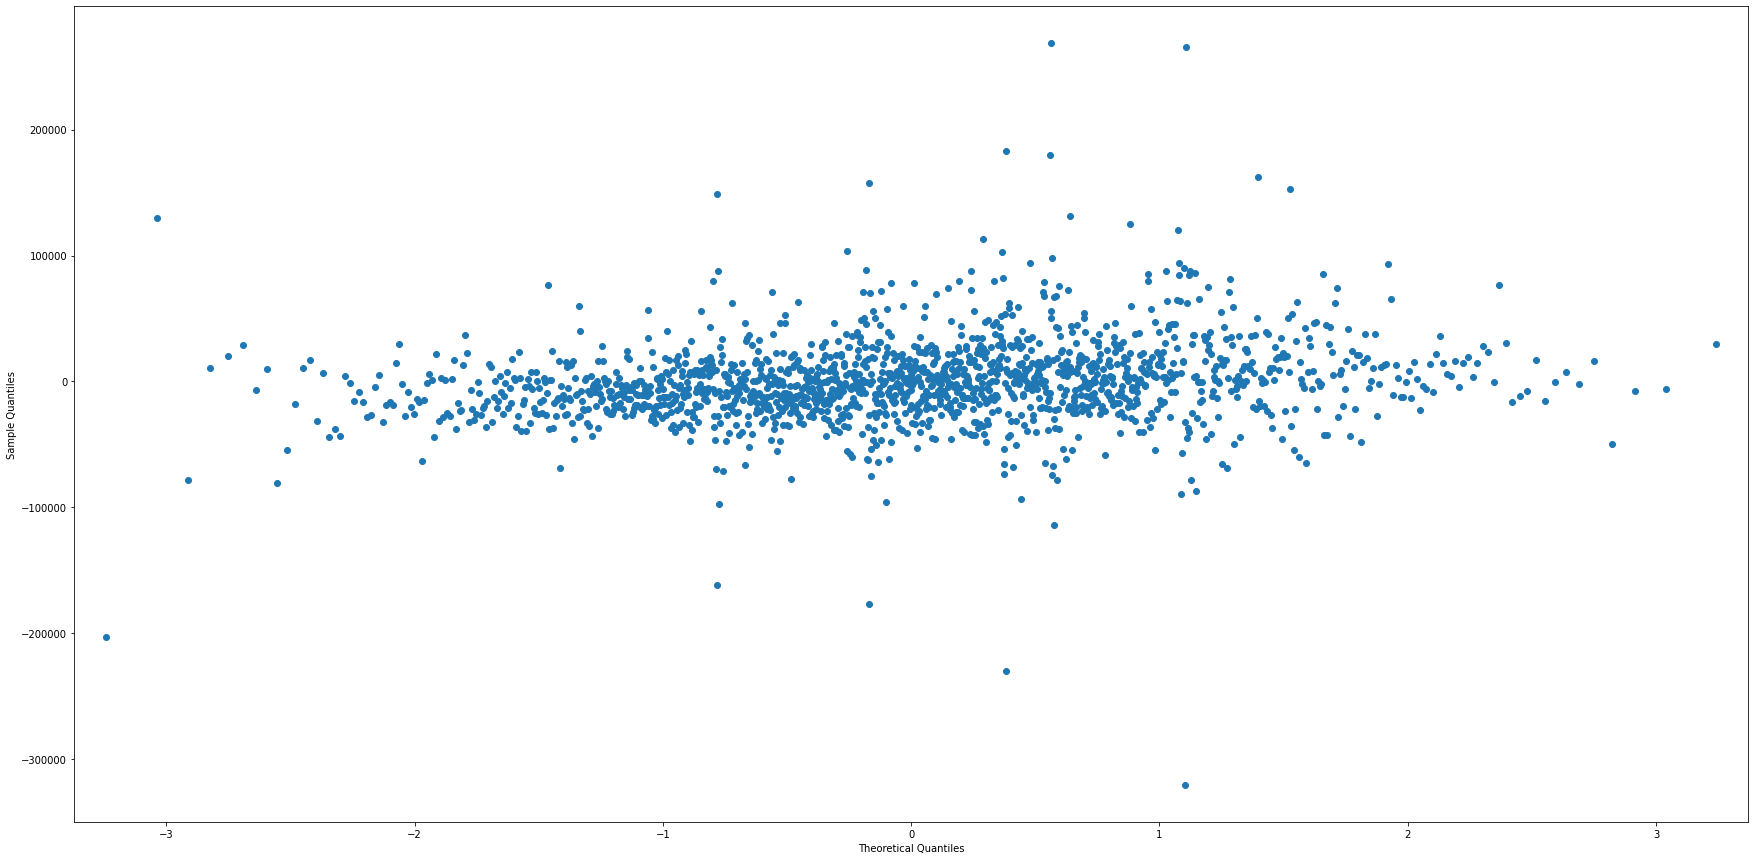

In [26]:
fig = sm.qqplot(residuals)
plt.show()

El modelo no es el apropiado a partir de los resultados obtenidos en el qqplot

In [29]:
acorr_ljungbox(residuals, lags=[7], return_df=True)

,lb_stat,lb_pvalue
7,6.667974,0.464249
